In [1]:
import gymnasium as gym
import gymnasium.wrappers as gym_wrap
import math
import numpy as np
import pandas as pd
from pathlib import Path
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Callable, List, Optional
import csv
import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.ion()


import seaborn as sns
from tqdm.notebook import tqdm

from IPython.display import Video
from ipywidgets import interact

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
sns.set_context("talk")

In [ ]:
DIRECTORY_OUTPUT = "output"
DIRECTORY_MODELS = Path(f"{DIRECTORY_OUTPUT}/models/")
DIRECTORY_FIGURES = Path(f"{DIRECTORY_OUTPUT}/images/")
DIRECTORY_LOGS = Path(f"{DIRECTORY_OUTPUT}/logs/")

if not DIRECTORY_FIGURES.exists():
    DIRECTORY_FIGURES.mkdir(parents=True)

if not DIRECTORY_MODELS.exists():
    DIRECTORY_MODELS.mkdir(parents=True)

if not DIRECTORY_LOGS.exists():
    DIRECTORY_LOGS.mkdir(parents=True)

print(DIRECTORY_OUTPUT)
print(DIRECTORY_MODELS)
print(DIRECTORY_FIGURES)
print(DIRECTORY_LOGS)

In [ ]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Logs and model saving

In [ ]:
def save_model(policy, iteration):
    """Save the model parameters."""
    model_path = DIRECTORY_MODELS / f"model_iter_{iteration}.pt"
    torch.save(policy.state_dict(), model_path)

def save_log(iteration, rewards, sigmas):
    """Save the logs in a CSV file."""
    log_path = DIRECTORY_LOGS / "training_log.csv"
    data = {"iteration": iteration, "reward": rewards[-1], "sigma": sigmas[-1]}

    df = pd.DataFrame([data])
    if log_path.exists():
        df.to_csv(log_path, mode="a", header=False, index=False)
    else:
        df.to_csv(log_path, mode="w", header=True, index=False)

## Plotting

In [ ]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

def plot_reward(iteration, reward_list, sigmas):
    """
    Plot the reward per generation and a moving average.

    Args:
        generation (int): Current generation number.
        reward_list (list): List of best rewards per generation.
        sigmas (list): List of sigma values per generation.
    """
    plt.figure(1)
    rewards_tensor = torch.tensor(reward_list, dtype=torch.float)

    if len(rewards_tensor) >= 11:
        eval_reward = torch.clone(rewards_tensor[-10:])
        mean_eval_reward = round(torch.mean(eval_reward).item(), 2)
        std_eval_reward = round(torch.std(eval_reward).item(), 2)
        plt.clf()
        plt.title(
            f'Iter #{iteration}: Best Reward: {reward_list[-1]:.2f}, Sigma: {sigmas[-1]:.4f}, '
            f'[{mean_eval_reward:.1f}±{std_eval_reward:.1f}]'
        )
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.plot(rewards_tensor.numpy())

    if len(rewards_tensor) >= 50:
        reward_f = torch.clone(rewards_tensor[:50])
        means = rewards_tensor.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.ones(49) * torch.mean(reward_f), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        display.display(plt.gcf())
        display.clear_output(wait=True)


In [ ]:
class SkipFrame(gym.Wrapper):
    """
    Gym environments custom wrapper to skip a specified number of frames.

    Attributes:
        env (gym.Env): The environment to wrap.
        _skip (int): The number of frames to skip.

    Methods:
        step(action):
            Repeats the given action for the specified number of frames and
            accumulates the reward.
    """
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        for _ in range(self._skip):
            state, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            if terminated:
                break
        return state, total_reward, terminated, truncated, info


## CNN

### Define the CNN for feature extraction

In [ ]:
class CNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for feature extraction from high-dimensional input.

    The network expects input images with dimensions (channels, 84, 84) and outputs a feature vector
    that is further processed to produce the action values.
    """
    def __init__(self, input_dimensions, output_dimensions):
        """
        Initialize the CNN.

        Parameters
        ----------
        input_dimensions : tuple
            A tuple (channels, height, width). For your setup, expected: (4, 84, 84)
            (4 frames stacked, 84x84 each).
        output_dimensions : int
            The number of outputs (i.e. action dimensions).
        """
        super().__init__()
        channel_n, height, width = input_dimensions
        if height != 84 or width != 84:
            raise ValueError(f"Invalid input ({height}, {width})-shape. Expected: (84, 84)")

        self.conv_net = nn.Sequential(
            nn.Conv2d(in_channels=channel_n, out_channels=16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )

        conv_output_size = 2592

        self.fc_net = nn.Sequential(
            nn.Linear(conv_output_size, 256),
            nn.ReLU(),
            nn.Linear(256, output_dimensions)
        )

    def forward(self, input):
        x = self.conv_net(input)
        x = self.fc_net(x)

        steering = torch.tanh(x[:, 0])
        gas = torch.sigmoid(x[:, 1])
        brake = torch.sigmoid(x[:, 2])

        return torch.stack((steering, gas, brake), dim=1)


## CNNPolicy

### Define the CNNPolicy that wraps the CNN and adds parameter management

In [ ]:
class CNNPolicy(nn.Module):
    """
    A neural network policy for CarRacing using a CNN to process image inputs.

    Methods
    -------
    forward(observation: np.ndarray) -> np.ndarray
        Given an observation, compute the action vector.
    get_params() -> np.ndarray
        Return the network parameters as a flat numpy array.
    set_params(params: np.ndarray) -> None
        Set the network parameters from a flat numpy array.
    """
    def __init__(self, input_dimensions, action_size):
        """
        Initialize the CNNPolicy.

        Parameters
        ----------
        input_dimensions : tuple
            The dimensions of the input image (channels, height, width), e.g. (4, 84, 84)
            (4 frames stacked, 84x84 each).
        action_size : int
            The number of continuous actions (for CarRacing: 3).
        """
        super(CNNPolicy, self).__init__()
        self.cnn = CNN(input_dimensions, action_size).to(device)

    def forward(self, observation: np.ndarray) -> np.ndarray:
        """
        Compute the action for a given observation.

        The observation is expected to be in the shape (4, 84, 84) as produced by our
        preprocessing pipeline (frame stacking, grayscale, resizing). If the observation
        is provided as a tuple (as in Gymnasium v3), we extract the first element.

        Parameters
        ----------
        observation : np.ndarray
            The input observation.

        Returns
        -------
        np.ndarray
            The output action vector (steering, gas, braking).
        """
        with torch.no_grad():
            # If observation is provided as a tuple, extract the observation.
            if isinstance(observation, (tuple, list)):
                observation = observation[0]

            # The observation is already channel-first (4, 84, 84), so no transpose is needed.
            observation_tensor = torch.tensor(observation, dtype=torch.float32, device=device)

            # If the observation is not batched, add a batch dimension.
            if observation_tensor.ndim == 3:
                observation_tensor = observation_tensor.unsqueeze(0)
            output_tensor = self.cnn(observation_tensor)
            action = output_tensor.squeeze().detach().cpu().numpy()

            return action

    def get_params(self) -> np.ndarray:
        """
        Get a flat numpy array of the network parameters.

        Returns
        -------
        np.ndarray
            The flattened parameters.
        """
        params_tensor = torch.nn.utils.parameters_to_vector(self.parameters())
        return params_tensor.detach().cpu().numpy()

    def set_params(self, params: np.ndarray) -> None:
        """
        Set the network parameters from a flat numpy array.

        Parameters
        ----------
        params : np.ndarray
            The new parameters.
        """
        params_tensor = torch.tensor(params, dtype=torch.float32, device=device)
        torch.nn.utils.vector_to_parameters(params_tensor, self.parameters())


## Objective Function

### Define the Objective Function for evaluating the policy

In [ ]:
class ObjectiveFunction:
    """
    Objective function for evaluating a policy in the given environment.

    This function runs the policy for a number of episodes and returns the negative of
    the average reward (to transform the problem into a minimization task).

    Parameters
    ----------
    env : gym.Env
        The environment (CarRacing-v3) in which to evaluate the policy.
    policy : nn.Module
        The policy to evaluate.
    num_episodes : int, optional
        Number of episodes per evaluation.
    max_time_steps : float, optional
        Maximum time steps per episode.
    minimization_solver : bool, optional
        If True, returns negative reward for minimization.
    """
    def __init__(self, env: gym.Env, policy: nn.Module, num_episodes: int = 1,
                 max_time_steps: float = float("inf"), minimization_solver: bool = True):
        self.env = env
        self.policy = policy
        self.num_episodes = num_episodes
        self.max_time_steps = max_time_steps
        self.minimization_solver = minimization_solver
        self.num_evals = 0

    def eval(self, policy_params: np.ndarray, num_episodes: Optional[int] = None,
             max_time_steps: Optional[float] = None) -> float:
        """
        Evaluate the policy with the given parameters.

        Parameters
        ----------
        policy_params : np.ndarray
            The parameters to evaluate.
        num_episodes : int, optional
            Number of episodes for evaluation.
        max_time_steps : float, optional
            Maximum time steps per episode.

        Returns
        -------
        float
            The (possibly negated) average total reward.
        """
        self.policy.set_params(policy_params)
        self.num_evals += 1

        if num_episodes is None:
            num_episodes = self.num_episodes
        if max_time_steps is None:
            max_time_steps = self.max_time_steps

        total_reward_sum = 0.0
        for _ in range(num_episodes):
            observation, info = self.env.reset()
            episode_reward = 0.0
            for t in range(int(max_time_steps)):
                action = self.policy(observation)
                observation, reward, terminated, truncated, info = self.env.step(action)
                episode_reward += reward
                if terminated or truncated:
                    break
            total_reward_sum += episode_reward

        avg_reward = total_reward_sum / num_episodes

        # Convert to a minimization problem if required.
        if self.minimization_solver:
            avg_reward *= -1.0
        return avg_reward

    def __call__(self, policy_params: np.ndarray, num_episodes: Optional[int] = None,
                 max_time_steps: Optional[float] = None) -> float:
        return self.eval(policy_params, num_episodes, max_time_steps)

## CEM

### Define the Cross-Entropy Method (CEM) optimization function

In [ ]:
def cem_uncorrelated(
    objective_function: Callable[[np.ndarray], float],
    mean_array: np.ndarray,
    var_array: np.ndarray,
    max_iterations: int = 500,
    sample_size: int = 50,
    elite_frac: float = 0.2,
    print_every: int = 10,
    success_score: float = float("inf"),
    num_evals_for_stop: Optional[int] = None,
    hist_dict: Optional[dict] = None,
    policy: Optional[nn.Module] = None,
    save_interval: int = 50
) -> np.ndarray:
    """
    Cross-Entropy Method (CEM) optimization.

    Parameters
    ----------
    objective_function : Callable[[np.ndarray], float]
        The objective function to evaluate policies.
    mean_array : np.ndarray
        Initial mean parameters.
    var_array : np.ndarray
        Initial variance for each parameter.
    max_iterations : int, optional
        Maximum number of iterations.
    sample_size : int, optional
        Number of candidate samples per iteration.
    elite_frac : float, optional
        Fraction of top-performing samples to use for updating.
    print_every : int, optional
        Frequency of printing and plotting progress.
    success_score : float, optional
        Score threshold for early stopping.
    num_evals_for_stop : Optional[int], optional
        If provided, evaluate the mean parameters every iteration.
    hist_dict : Optional[dict], optional
        Dictionary to store history.

    Returns
    -------
    np.ndarray
        The optimized mean parameters.
    """
    assert 0.0 < elite_frac <= 1.0
    n_elite = math.ceil(sample_size * elite_frac)

    # Lists for real-time plotting
    reward_list = []
    sigma_list = []

    for iteration_index in range(max_iterations):
        # Sample new candidate solutions from the multivariate normal distribution.
        x_array = np.random.randn(sample_size, mean_array.shape[0]) * np.sqrt(var_array) + mean_array

        # Evaluate each candidate solution.
        score_array = np.array([objective_function(x) for x in x_array])
        sorted_indices = np.argsort(score_array)
        elite_indices = sorted_indices[:n_elite]
        elite_x_array = x_array[elite_indices]

        # Update mean and variance based on the elite samples.
        mean_array = np.mean(elite_x_array, axis=0)
        var_array = np.var(elite_x_array, axis=0)
        score = np.mean(score_array[elite_indices])

        # Append values for plotting.
        reward_list.append(score)
        sigma_list.append(np.mean(var_array))

        if iteration_index % print_every == 0:
            print(f"Iteration {iteration_index}\tScore {score}")
            plot_reward(iteration_index, reward_list, sigma_list)

        if iteration_index % save_interval == 0:
            save_model(policy, iteration_index)

        save_log(iteration_index, reward_list, sigma_list)

        if hist_dict is not None:
            hist_dict[iteration_index] = [score] + mean_array.tolist() + var_array.tolist()

        if num_evals_for_stop is not None:
            score = objective_function(mean_array)
        if score <= success_score:
            break

    return mean_array

## Train

### Train the CEM agent on the CarRacing environment

In [ ]:
if __name__ == "__main__":

    # Create the CarRacing-v3 environment (continuous mode)
    env = gym.make("CarRacing-v3",
                render_mode="rgb_array",
                lap_complete_percent=0.95,
                continuous=True)

    env = SkipFrame(env, skip=4)
    env = gym_wrap.GrayscaleObservation(env)
    env = gym_wrap.ResizeObservation(env, shape=(84, 84))
    env = gym_wrap.FrameStackObservation(env, stack_size=4)

    input_dimensions = (4, 84, 84)  # 4 frames, 84x84 each.
    action_size = 3  # [steering, gas, braking]

    cnn_policy = CNNPolicy(input_dimensions, action_size)

    # Set up the objective function.
    objective_function = ObjectiveFunction(env, cnn_policy, num_episodes=1, max_time_steps=100)

    hist_dict = {}
    num_params = len(cnn_policy.get_params())
    init_mean_array = np.random.random(num_params)
    init_var_array = np.ones(num_params) * 1000.0

    # Optimize the policy parameters using CEM.
    optimized_policy_params = cem_uncorrelated(
        objective_function=objective_function,
        mean_array=init_mean_array,
        var_array=init_var_array,
        max_iterations=200,
        sample_size=10,
        elite_frac=0.3,
        print_every=1,
        success_score=-700,
        hist_dict=hist_dict,
        policy=cnn_policy,
        save_interval=10
    )

    # # Optionally, update the policy with the optimized parameters.
    # cnn_policy.set_params(optimized_policy_params)

    # Close the environment.
    env.close()

### Plot train results

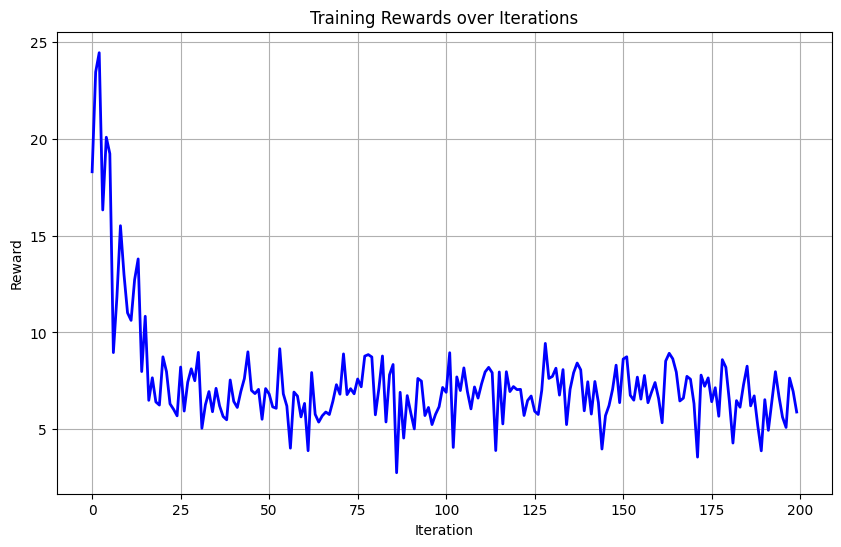

In [ ]:
df = pd.read_csv('output/logs/training_log.csv')

iterations = df.iloc[:, 0]
rewards = df.iloc[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(iterations, rewards, 'b-', linewidth=2)
plt.title('Training Rewards over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

## Testing the trained agent

In [ ]:
def video_selector(file_path: List[Path]) -> Video:
    return Video(file_path, embed=True, html_attributes="controls autoplay loop")

In [ ]:
VIDEO_PREFIX_CEM_TRAINED = "cem_carracing_trained"
NUM_EPISODES = 3

file_path_list = [
    DIRECTORY_FIGURES / f"{VIDEO_PREFIX_CEM_TRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("CarRacing-v3",
                render_mode="rgb_array",
                lap_complete_percent=0.95,
                continuous=True)

env = SkipFrame(env, skip=4)
env = gym_wrap.GrayscaleObservation(env)
env = gym_wrap.ResizeObservation(env, shape=(84, 84))
env = gym_wrap.FrameStackObservation(env, stack_size=4)

env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(DIRECTORY_FIGURES),
    name_prefix=VIDEO_PREFIX_CEM_TRAINED,
    episode_trigger=lambda episode: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

objective_function = ObjectiveFunction(env=env, policy=cnn_policy)

objective_function.eval(optimized_policy_params, num_episodes=NUM_EPISODES, max_time_steps=1000)

env.close()

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list);